##Summary
###Parameters-978598
###Epochs=110
###Validation Accuracy=94.34

**Mounting Google Drive**

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/gdrive')
#* updating filepath to your Google Drive

filepath="/content/gdrive/My Drive/EIP2/Models/DenseNet/saved_models/densent_bc/weights_densenetbc_2.best.hdf5"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


###Resources for insight



Few resources which I found useful in implementing this project:
*   **Global Average Pooling**-https://github.com/taki0112/Densenet-Tensorflow/blob/master/Cifar10/Densenet_Cifar10.py
*   **Architecture_1**-https://github.com/jeffmomo/Tensorflow-DenseNetBC/blob/master/densenet.py
*  **Architecutre_2**-https://github.com/flyyufelix/cnn_finetune/blob/master/densenet121.py
* **Data Augmentation**-https://towardsdatascience.com/different-ways-of-improving-training-accuracy-c526db15a5b2



**Necessary Package Installation**

In [0]:
!pip install -q keras
import keras
!pip install h5py
!pip install simplejson

Using TensorFlow backend.


    100% |████████████████████████████████| 81kB 2.9MB/s 
  Running setup.py bdist_wheel for simplejson ... - \ | done
  Stored in directory: /root/.cache/pip/wheels/5d/1a/1e/0350bb3df3e74215cd91325344cc86c2c691f5306eb4d22c77
Successfully built simplejson


**Imports**

In [0]:
import math
import keras
import numpy as np
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation,GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,SeparableConv2D
from keras.layers import Concatenate
from keras.regularizers import l1 ,l2
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint
from keras.optimizers import SGD

In [0]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf
from keras import backend as k

# Don't pre-allocate memory; allocate as-needed
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))

### CIFAR 10 dataset Description
 60000, images 32x32 colour images in 10 classes, with 6000 images per class.
#### There are 50000 training images and 10000 test images.
The ten classes are as: airplane, automobile, bird, deer, dog, cat, horse, frog, ship, truck.

#### Loading CIFAR dataset and Converting train and test  labels to One-hot encoding

In [0]:
num_classes=10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
img_height, img_width, channel = x_train.shape[1],x_train.shape[2],x_train.shape[3]


y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

170500096/170498071 [==============================] - 12s 0us/step


###Normalization 

In [0]:
'''
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
'''

### Denseblock function

In [0]:
# Dense Block
def add_denseblock(input, l, num_filter = 16, dropout_rate = 0.2):
  temp = input
  for _ in range(int(l)):
    BatchNorm = BatchNormalization(beta_regularizer=l2(wd),gamma_regularizer=l2(wd))(temp)
    relu = Activation('relu')(BatchNorm)
    Conv2D_1_1 = Conv2D(int(num_filter*4),(1,1), use_bias= False, padding='same',kernel_initializer="he_uniform",kernel_regularizer=l2(wd))(relu)
    if dropout_rate>0:
      Conv2D_1_1 = Dropout(dropout_rate)(Conv2D_1_1)
    BatchNorm = BatchNormalization(beta_regularizer=l2(wd),gamma_regularizer=l2(wd))(Conv2D_1_1)
    relu = Activation('relu')(BatchNorm)
    Conv2D_3_3 = Conv2D(int(num_filter), (3,3), use_bias=False ,padding='same',kernel_initializer="he_uniform",kernel_regularizer=l2(wd))(relu)
    if dropout_rate>0:
      Conv2D_3_3 = Dropout(dropout_rate)(Conv2D_3_3)
    concat = Concatenate(axis=-1)([temp,Conv2D_3_3])
    temp = concat
        
  return temp

### Transition block, with composite layers of BatchNorm-Activation-BottleneckConv2D1x1-Dropout-2x2Pooling between two dense blocks

In [0]:
def add_transition(input,  dropout_rate = 0.2,num_filter = 16,):
    BatchNorm = BatchNormalization(beta_regularizer=l2(wd),gamma_regularizer=l2(wd))(input)
    relu = Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = Conv2D(int(num_filter), (1,1), use_bias=False ,padding='same',kernel_initializer="he_uniform",kernel_regularizer=l2(wd))(relu)
    if dropout_rate>0:
      Conv2D_BottleNeck = Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = AveragePooling2D()(Conv2D_BottleNeck)
    
    return avg

### Final Dense layer following global average pooling of 2x2

In [0]:
def output_layer(input):
    BatchNorm = BatchNormalization(beta_regularizer=l2(wd),gamma_regularizer=l2(wd))(input)
    relu = Activation('relu')(BatchNorm)
    GP = GlobalAveragePooling2D()(relu)
    output = Dense(num_classes, activation='softmax',kernel_regularizer=l2(wd))(GP)
    
    return output

#### Hyperparameters
* Weight Decay
* Addition of filter from previous layer
* number of filters for Conv2D(1x1)
* compression rate
* compression rate in block1
* compression rate in block2
* no of layers in each block
* dropout rate


In [0]:
wd=1e-4
global wd
growth_rate=13
num_filter=4*growth_rate
reduction=0.5
depth=100
reduction_1=0.5
reduction_2=0.5
no_layer=(depth-4)//6
dropout_rate=0.2


input = Input(shape=(img_height, img_width, channel,))
First_Conv2D = Conv2D(num_filter, (3,3), use_bias=False ,padding='same', kernel_initializer='he_uniform', bias_initializer='zeros',
                      kernel_regularizer=l2(wd))(input)

First_Block = add_denseblock(First_Conv2D,no_layer ,growth_rate ,dropout_rate)
num_filter=math.floor((num_filter+no_layer*growth_rate))*reduction_1
First_Transition = add_transition(First_Block, dropout_rate, num_filter=num_filter)

Second_Block = add_denseblock(First_Transition,no_layer,growth_rate,dropout_rate)
num_filter=math.floor((num_filter+no_layer*growth_rate))*reduction_2
Second_Transition = add_transition(Second_Block, dropout_rate, num_filter=num_filter)

Third_Block = add_denseblock(Second_Transition,no_layer,growth_rate,dropout_rate )
#Third_Transition = add_transition(Third_Block, dropout_rate, num_filter=171)

#Last_Block = add_denseblock(Third_Transition, dropout_rate,l, num_filter)
output = output_layer(Third_Block)


### Model summary for above defined densenet architecture

In [0]:
model = Model(inputs=[input], outputs=[output])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_432 (Conv2D)             (None, 32, 32, 52)   1404        input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_431 (BatchN (None, 32, 32, 52)   208         conv2d_432[0][0]                 
__________________________________________________________________________________________________
activation_431 (Activation)     (None, 32, 32, 52)   0           batch_normalization_431[0][0]    
__________________________________________________________________________________________________
conv2d_433

#### Saving model architectures as json string

In [0]:
from pathlib import Path
import simplejson
#serialize model to JSON
filepath_json=Path('/content/gdrive/My Drive/EIP2/Models/DenseNet/saved_models')
model_json = model.to_json()
with open(filepath_json/"densenet_bc_2.json", "w") as json_file:
    json_file.write(simplejson.dumps(simplejson.loads(model_json), indent=4))

### Model Compilation: defining loss function, preferred optimizer fucntion

In [0]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
            optimizer=SGD(lr=1e-1,decay=1e-6, momentum=0.9, nesterov=True),
              metrics=['accuracy'])

###Callbacks

In [0]:
filepath="/content/gdrive/My Drive/EIP2/Models/DenseNet/saved_models/densenet_bc/weights_densenetbc_2.best.hdf5"
#callbacks
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)
checkpoint_save = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint_save,learning_rate_reduction]

##Iteration -1

### Model training, using 50k training images as x_train & labels y_train with data augmentation .
###Batch_size- 64
###Epochs-70

In [0]:
from keras.preprocessing import image
#data augmentation
datagen = image.ImageDataGenerator(
    zoom_range=0.3,
    rotation_range=15,
    horizontal_flip=True,
    fill_mode='nearest',
    
    )
datagen.fit(x_train)

In [0]:
batch_size=64
epochs=70
# Fit the model on the batches generated by datagen.flow().
model.fit_generator(datagen.flow(x_train, y_train,
                                 batch_size=batch_size),
                        steps_per_epoch=len(x_train) / batch_size,
                        epochs=epochs,validation_data=(x_test, y_test),callbacks=callbacks_list)

Epoch 1/70
782/781 [==============================] - 580s 741ms/step - loss: 3.3530 - acc: 0.4361 - val_loss: 4.5059 - val_acc: 0.2886

Epoch 00001: val_acc improved from -inf to 0.28860, saving model to /content/gdrive/My Drive/EIP2/Models/DenseNet/saved_models/densenet_bc/weights_densenetbc_2.best.hdf5
Epoch 2/70
782/781 [==============================] - 515s 659ms/step - loss: 2.5192 - acc: 0.5915 - val_loss: 2.8336 - val_acc: 0.5106

Epoch 00002: val_acc improved from 0.28860 to 0.51060, saving model to /content/gdrive/My Drive/EIP2/Models/DenseNet/saved_models/densenet_bc/weights_densenetbc_2.best.hdf5
Epoch 3/70
782/781 [==============================] - 514s 657ms/step - loss: 2.0578 - acc: 0.6492 - val_loss: 2.4044 - val_acc: 0.5792

Epoch 00003: val_acc improved from 0.51060 to 0.57920, saving model to /content/gdrive/My Drive/EIP2/Models/DenseNet/saved_models/densenet_bc/weights_densenetbc_2.best.hdf5
Epoch 4/70
782/781 [==============================] - 514s 658ms/step - l

##Loading Model architecture and best weights from the previous run

In [0]:
from keras.models import model_from_json
from pathlib import Path
filepath_json=Path('/content/gdrive/My Drive/EIP2/Models/DenseNet/saved_models')
# load json and create model
json_file = open(filepath_json/"densenet_bc_2.json", 'r')
loaded_model_json1 = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json1)
# load weights into new model
filepath=Path("/content/gdrive/My Drive/EIP2/Models/DenseNet/saved_models/densenet_bc")
loaded_model.load_weights(filepath/"weights_densenetbc_2.best.hdf5")
print("Loaded model from disk")

Loaded model from disk


## Model Compilation at a lower learning rate(Choosing learning rate from previous run)

In [0]:
# determine Loss function and Optimizer
loaded_model.compile(loss='categorical_crossentropy',
            optimizer=SGD(lr=0.00039,decay=1e-6, momentum=0.9, nesterov=True),
              metrics=['accuracy'])

In [0]:
from keras.preprocessing import image
#data augmentation
datagen = image.ImageDataGenerator(
    zoom_range=0.3,
    rotation_range=15,
    horizontal_flip=True,
    fill_mode='nearest',
    
    )
datagen.fit(x_train)

In [0]:
filepath1="/content/gdrive/My Drive/EIP2/Models/DenseNet/saved_models/densenet_bc/weights_densenetbc_2-{epoch:02d}-{val_acc:.2f}.hdf5"
#callbacks
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-8)
checkpoint_save = ModelCheckpoint(filepath1, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint_save,learning_rate_reduction]

## Iteration -2


## Running Training again with smaller batch_size
### Batch Size=32
###Epochs=20

In [0]:
batch_size=32
epochs=20
# Fit the model on the batches generated by datagen.flow().
loaded_model.fit_generator(datagen.flow(x_train, y_train,
                                 batch_size=batch_size),
                        steps_per_epoch=len(x_train) / batch_size,
                        epochs=epochs,validation_data=(x_test, y_test),callbacks=callbacks_list)

Epoch 1/20
1563/1562 [==============================] - 634s 406ms/step - loss: 0.3470 - acc: 0.9456 - val_loss: 0.4171 - val_acc: 0.9326

Epoch 00001: val_acc improved from -inf to 0.93260, saving model to /content/gdrive/My Drive/EIP2/Models/DenseNet/saved_models/densenet_bc/weights_densenetbc_2-01-0.93.hdf5
Epoch 2/20
1563/1562 [==============================] - 606s 388ms/step - loss: 0.3463 - acc: 0.9454 - val_loss: 0.4140 - val_acc: 0.9332

Epoch 00002: val_acc improved from 0.93260 to 0.93320, saving model to /content/gdrive/My Drive/EIP2/Models/DenseNet/saved_models/densenet_bc/weights_densenetbc_2-02-0.93.hdf5
Epoch 3/20
1563/1562 [==============================] - 606s 388ms/step - loss: 0.3475 - acc: 0.9447 - val_loss: 0.4125 - val_acc: 0.9364

Epoch 00003: val_acc improved from 0.93320 to 0.93640, saving model to /content/gdrive/My Drive/EIP2/Models/DenseNet/saved_models/densenet_bc/weights_densenetbc_2-03-0.94.hdf5
Epoch 4/20
1563/1562 [==============================] - 60

In [0]:
filepath2=Path("/content/gdrive/My Drive/EIP2/Models/DenseNet/saved_models/densenet_bc")
loaded_model.load_weights(filepath2/"weights_densenetbc_2-05-0.94.hdf5")

### Validation Accuracy

In [0]:
# Testing model on 10k test images
score = loaded_model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 41s 4ms/step
Test loss: 0.40656382205486297
Test accuracy: 0.9373


## Plotting Confusion Matrix

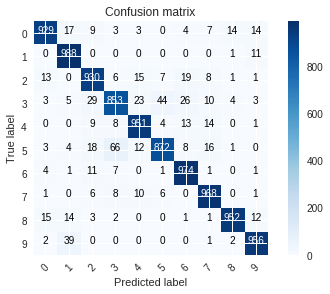

In [0]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import seaborn as sns
%matplotlib inline
# Look at confusion matrix 
#Note, this code is taken straight from the SKLEARN website, an nice way of viewing confusion matrix.
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = loaded_model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test, axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

## Looking into those images where model was wrong by the maximum margin

Number of misclassification 627


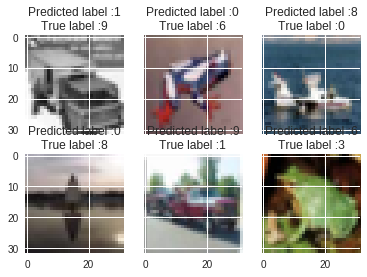

In [0]:
# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)
print("Number of misclassification",sum(errors))
Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_test_errors = x_test[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((32,32,3)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1
    # Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_test_errors, Y_pred_classes_errors, Y_true_errors)

## Data Augmentation without zoom and rotation

In [0]:
from keras.preprocessing import image
#data augmentation
datagen = image.ImageDataGenerator(
    horizontal_flip=True,
    fill_mode='nearest',
    
    )
datagen.fit(x_train)

In [0]:
filepath1="/content/gdrive/My Drive/EIP2/Models/DenseNet/saved_models/densenet_bc/weights_densenetbc_2_1-{epoch:02d}-{val_acc:.2f}.hdf5"
#callbacks
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-8)
checkpoint_save = ModelCheckpoint(filepath1, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint_save,learning_rate_reduction]

In [0]:
# determine Loss function and Optimizer
loaded_model.compile(loss='categorical_crossentropy',
            optimizer=SGD(lr=0.001,decay=1e-6, momentum=0.9, nesterov=True),
              metrics=['accuracy'])

## Iteration 3

## Training again 
### Batch Size=32
### Epochs=20

In [0]:
batch_size=32
epochs=20
# Fit the model on the batches generated by datagen.flow().
loaded_model.fit_generator(datagen.flow(x_train, y_train,
                                 batch_size=batch_size),
                        steps_per_epoch=len(x_train) / batch_size,
                        epochs=epochs,validation_data=(x_test, y_test),callbacks=callbacks_list)

Epoch 1/20
1563/1562 [==============================] - 601s 385ms/step - loss: 0.2808 - acc: 0.9697 - val_loss: 0.3782 - val_acc: 0.9397

Epoch 00001: val_acc improved from -inf to 0.93970, saving model to /content/gdrive/My Drive/EIP2/Models/DenseNet/saved_models/densenet_bc/weights_densenetbc_2_1-01-0.94.hdf5
Epoch 2/20
1563/1562 [==============================] - 598s 383ms/step - loss: 0.2758 - acc: 0.9698 - val_loss: 0.3895 - val_acc: 0.9391

Epoch 00002: val_acc did not improve from 0.93970
Epoch 3/20
1563/1562 [==============================] - 599s 383ms/step - loss: 0.2740 - acc: 0.9709 - val_loss: 0.3891 - val_acc: 0.9404

Epoch 00003: val_acc improved from 0.93970 to 0.94040, saving model to /content/gdrive/My Drive/EIP2/Models/DenseNet/saved_models/densenet_bc/weights_densenetbc_2_1-03-0.94.hdf5
Epoch 4/20
1563/1562 [==============================] - 599s 383ms/step - loss: 0.2685 - acc: 0.9722 - val_loss: 0.3895 - val_acc: 0.9382

Epoch 00004: val_acc did not improve from

In [0]:
filepath2=Path("/content/gdrive/My Drive/EIP2/Models/DenseNet/saved_models/densenet_bc")
loaded_model.load_weights(filepath2/"weights_densenetbc_2_1-14-0.94.hdf5")

## Validation Accuracy

In [0]:
# Testing model on 10k test images
score = loaded_model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 41s 4ms/step
Test loss: 0.3775681419610977
Test accuracy: 0.9434


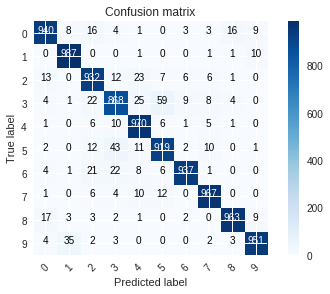

In [0]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import seaborn as sns
%matplotlib inline
# Look at confusion matrix 
#Note, this code is taken straight from the SKLEARN website, an nice way of viewing confusion matrix.
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = loaded_model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test, axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

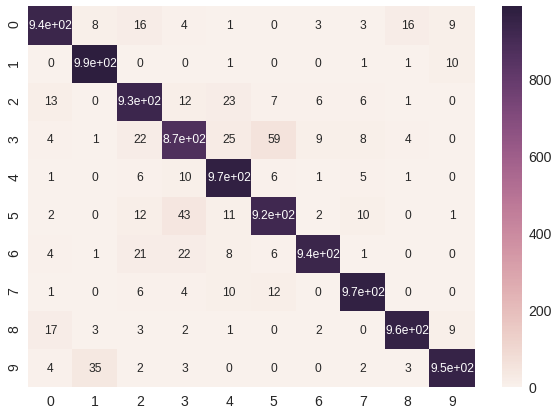

In [0]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
Y_pred = loaded_model.predict(x_test, verbose=2)
y_pred = np.argmax(Y_pred, axis=1)
 
#for ix in range(10):
    #print(ix, confusion_matrix(np.argmax(y_test,axis=1),y_pred)[ix].sum())
cm = confusion_matrix(np.argmax(y_test,axis=1),
                      y_pred)
#print(cm)
 
# Visualizing of confusion matrix
import seaborn as sn
import pandas  as pd
 
df_cm = pd.DataFrame(cm, range(10),
                  range(10))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 12})# font size